In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
data = pd.read_csv('Month_Value_1.csv', index_col=[0],
                            parse_dates=[0])

data.sort_index(inplace=True)

data.head(3)

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
Period,,,,
2015-01-01,1.601007e+07,12729,1257.763541,30024676
2015-01-02,1.580759e+07,11636,1358.507000,30024676
2015-01-03,2.204715e+07,15922,1384.697024,30024676


In [33]:
data = data.drop(['Revenue', 'Average_cost', 'The_average_annual_payroll_of_the_region'], axis= 1)

In [34]:
data.head()

,Sales_quantity
Period,
2015-01-01,12729
2015-01-02,11636
2015-01-03,15922
2015-01-04,15227
2015-01-05,8620


In [35]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

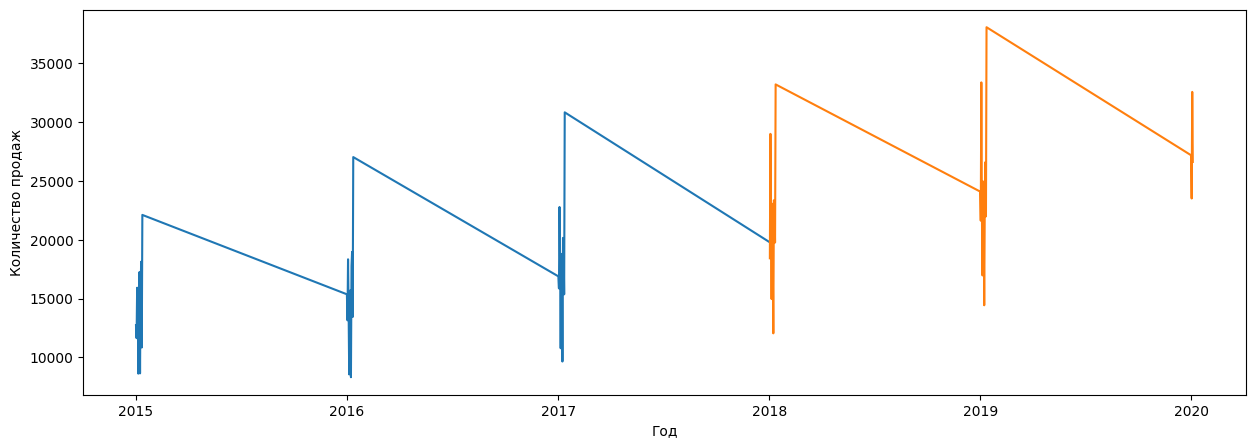

In [38]:
train, test = split_data(data, '01-Jan-2018')

plt.figure(figsize=(15,5))
plt.xlabel('Год')
plt.ylabel('Количество продаж')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [39]:
def create_features(df):
    """
    Делаем фичи из индекса datetime
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    return X

In [40]:
X_train, y_train = create_features(train), train['Sales_quantity']
X_test, y_test   = create_features(test), test['Sales_quantity']

X_train.shape, y_train.shape

((37, 6), (37,))

In [62]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth
Period,,,,,,
2015-01-01,3,1,1,2015,1,1
2015-01-02,4,1,1,2015,2,2
2015-01-03,5,1,1,2015,3,3
2015-01-04,6,1,1,2015,4,4
2015-01-05,0,1,1,2015,5,5


In [41]:
reg = CatBoostRegressor()

In [42]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)

In [43]:
importances = reg.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()

In [44]:
print(feature_importances)

quarter        0.000000
month          0.000000
dayofweek     13.718787
year          15.835968
dayofyear     33.711993
dayofmonth    36.733251
dtype: float64


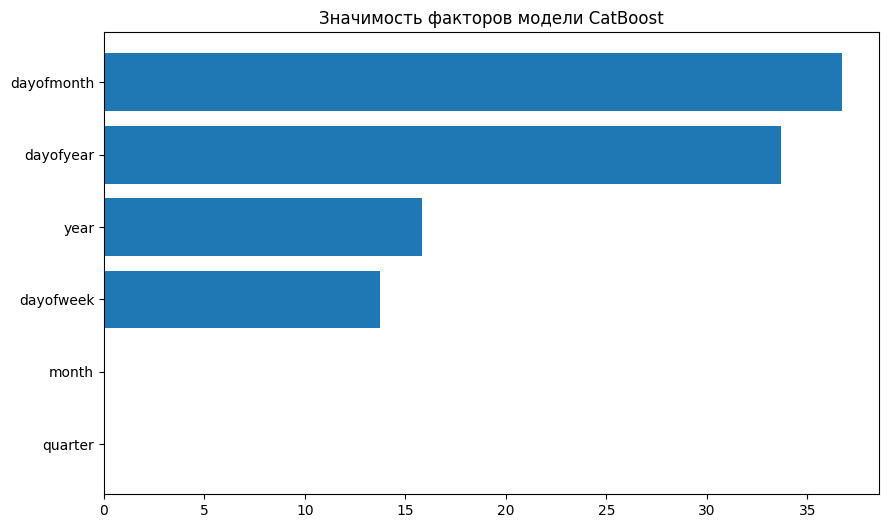

In [45]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('Значимость факторов модели CatBoost')
plt.show()

In [46]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('Прогноз на интервале от {0} до {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Год')
    plt.ylabel('Объем продаж')
    plt.plot(data.index,data, label='Исходные данные')
    plt.plot(X_test.index,X_test_pred, label='Прогноз')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

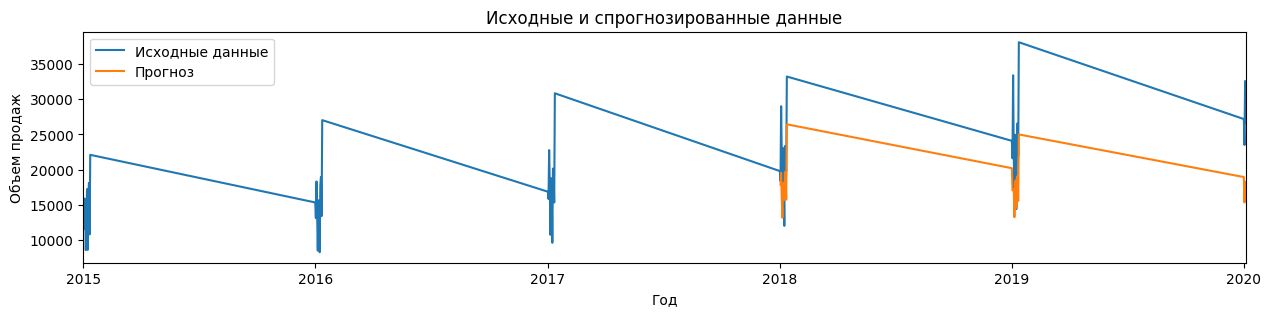

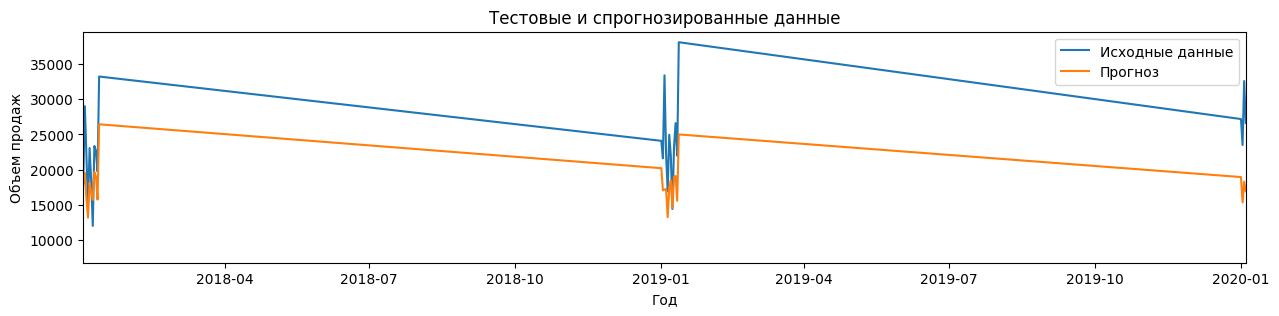

In [47]:
X_test_pred = reg.predict(X_test)
    
plot_performance(data, data.index[0].date(), data.index[-1].date(),
                 'Исходные и спрогнозированные данные')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Тестовые и спрогнозированные данные')

plt.legend()

plt.show()

C:\Users\aw347\AppData\Local\Temp\ipykernel_19812\3746914004.py:12: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(left=date_from, right=date_to)


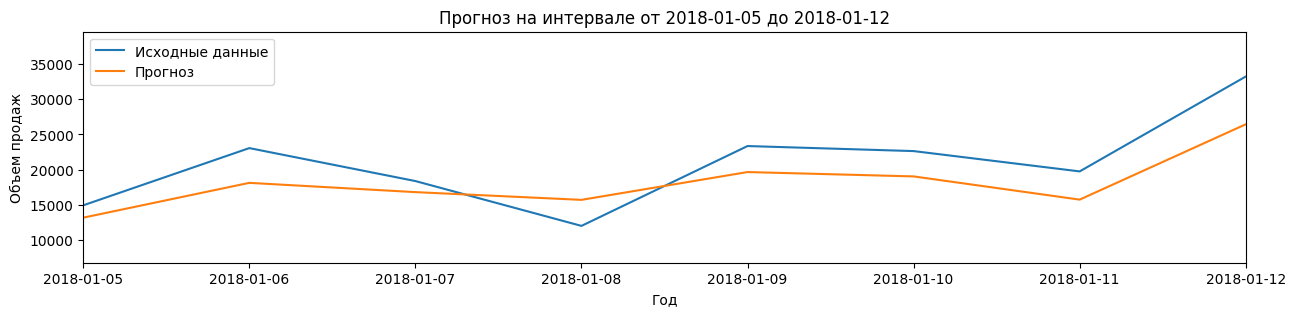

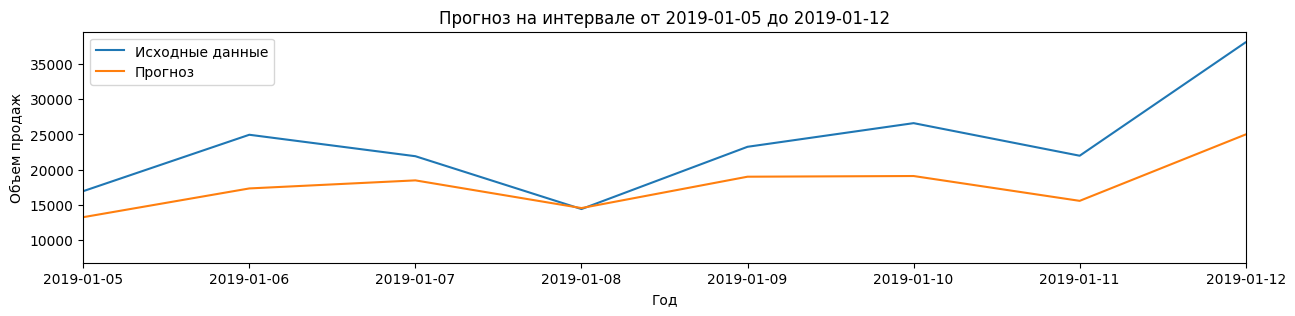

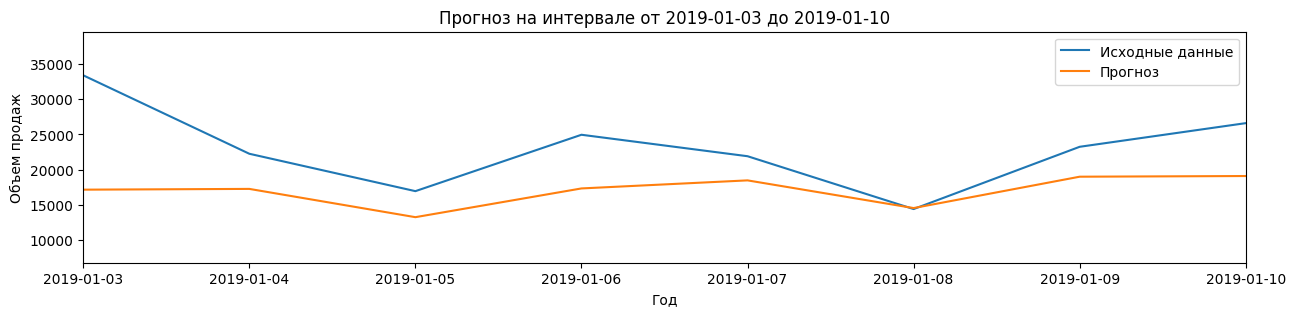

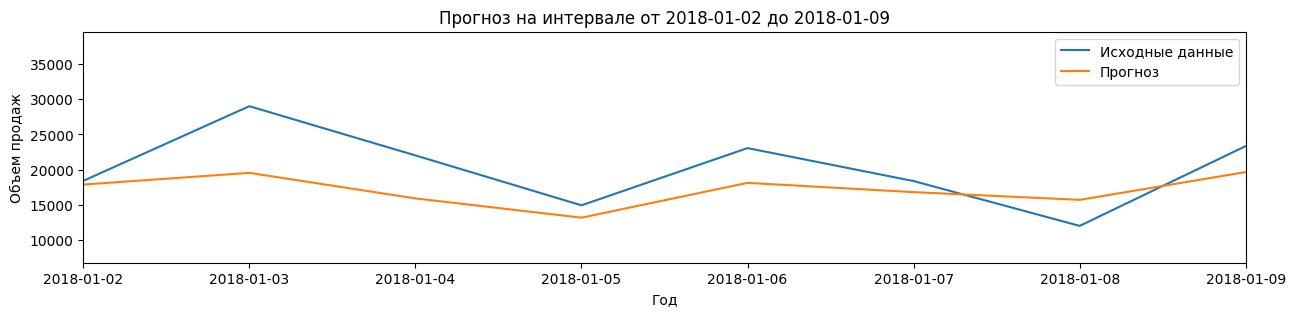

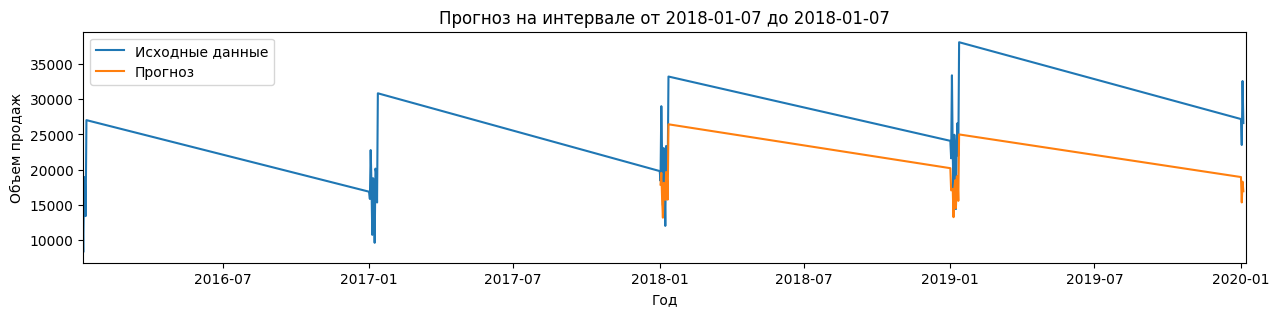

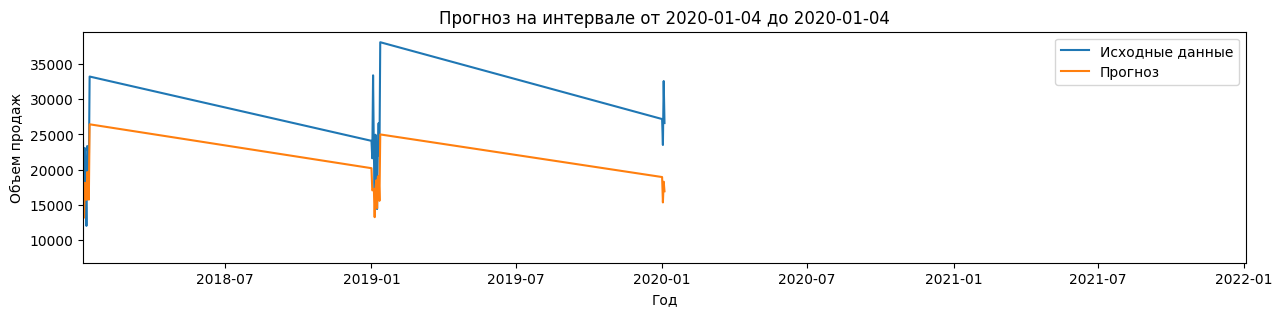

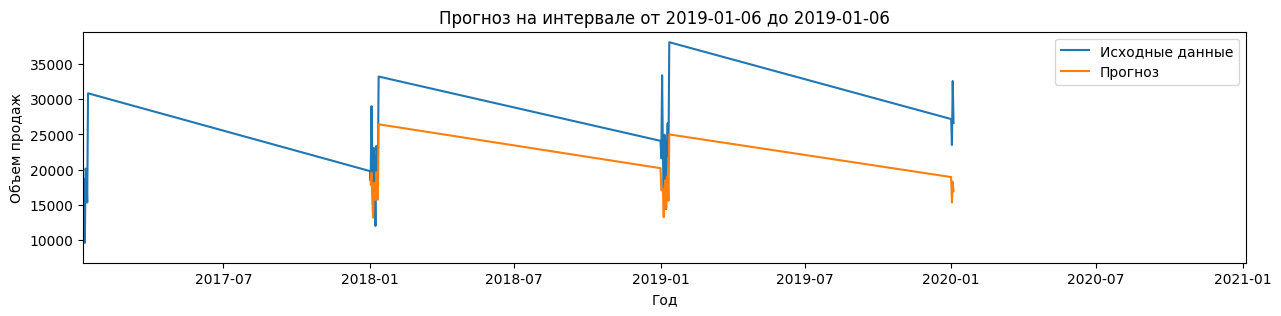

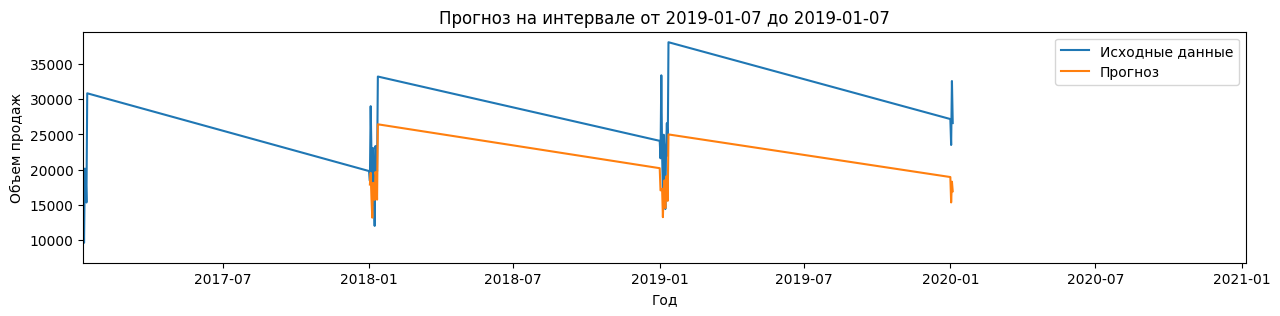

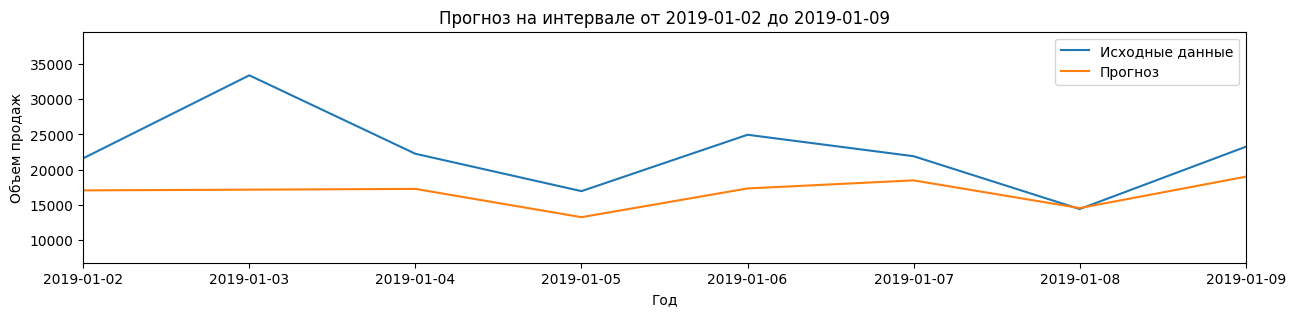

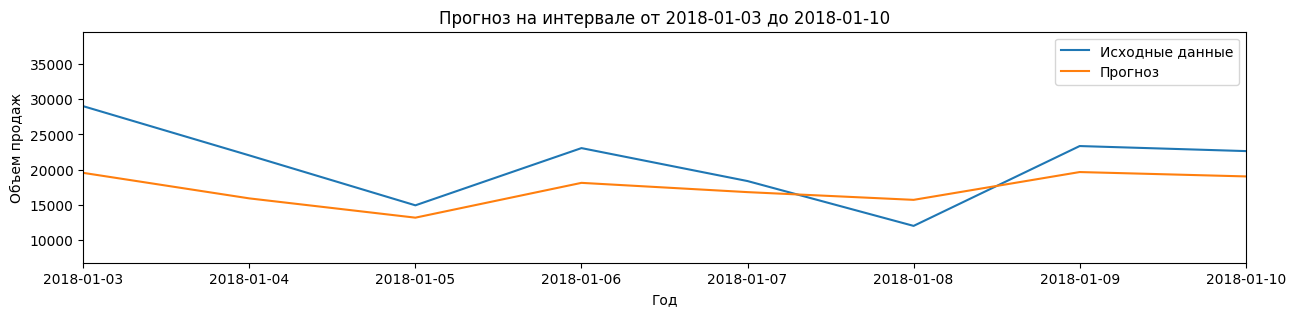

In [48]:
random_weeks = X_test[['year', 'dayofweek']].sample(10)
for week in random_weeks.iterrows():
    index = (X_test.year == week[1].year) & \
    (X_test.dayofweek == week[1].dayofweek)
    d = y_test[index]
    plot_performance(d, d.index[0].date(), d.index[-1].date())

In [49]:
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

51134574.07707499

In [50]:
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

5998.483708319062

In [53]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Рассчитываем MAPE"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [54]:
mean_absolute_percentage_error(y_test,X_test_pred)

23.666973719736877

In [55]:
error_by_dweek = []
random_dweeks = X_test[['year', 'dayofweek']].sample(10)
for dweek in random_dweeks.iterrows():
    index = (X_test.year == week[1].year) & \
            (X_test.dayofweek == week[1].dayofweek)
    error_by_dweek.append(mean_absolute_percentage_error(y_test[index], X_test_pred[index]))
pd.Series(error_by_dweek, index=random_weeks.index)

Period
2018-01-05    24.206319
2019-01-12    24.206319
2019-01-10    24.206319
2018-01-09    24.206319
2018-01-07    24.206319
2020-01-04    24.206319
2019-01-06    24.206319
2019-01-07    24.206319
2019-01-02    24.206319
2018-01-03    24.206319
dtype: float64